In [ ]:
pip install imutils

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Conv2D # la función Conv2D que sirve para crear cada una de las capas de convolución intermedias (ocultas) de las RNC
from keras.layers import MaxPool2D # la función MaxPool2D que sirve para crear cada una de las capas de max-pooling de las RNC
from keras.layers import Flatten # la función Flatten que sirve para crear la capa de flattening de las RNC
from keras.layers import Dense, Dropout

import seaborn as sns

In [2]:
#'C:\\Users\\Administrador.CRISASUSESTUDIO\\Desktop\\InteligenciaArtificial\\dataset_animal'
#C:\Users\Administrador.CRISASUSESTUDIO\Desktop\InteligenciaArtificial\dataset_animal

#TODO Recuerda usar el path correcto (dentro de este directorio ya están las carpetas de training_set y test_set)
dataset_path = 'C:\\Users\\Administrador.CRISASUSESTUDIO\\Desktop\\InteligenciaArtificial\\dataset_animal'

""""
CONSIDERACIONES:

-batch_size: un tamaño del lote, preferiblemente no muy grande para evitar colapsar.

-class_mode='binary' para clasificación binaria.
-Para más de dos clases,  class_mode='categorical'.

-El primer parámetro es el directorio. Para training y val, es el mismo directorio. Para test, la carpeta de test_set.

-subset: ahí ponemos para qué sirve ese lote (training o validation). Test no tiene subset.

-target_size: tamaño de las imágenes. Ahí tenemos que jugar con el tamño de las imágenes. Los modelos como VGG16, AlexNet, etc.. no cogen tamaños por debajo de 32.

-validation_split : este parámetro es FUNDAMENTAL para poder dividir el conjunto de validación y training.
"""

#Declaramos nuestras constantes
TARGET_SIZE = 150, 150
ALTO, ANCHO = TARGET_SIZE
IMG_CHANELS = 3

# Por conveniencia 32, 64 o 128. No hay un tamaño fijo
BATCH_SIZE = 32

print("Dimensiones: ", ALTO, ANCHO)

# Crear un generador para el conjunto de entrenamiento y validación ("manipulamos" un poco las imágenes)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

# Generador para el conjunto de entrenamiento
train_set = train_datagen.flow_from_directory(
    f'{dataset_path}/training_set/',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Generador para el conjunto de validación
val_set = train_datagen.flow_from_directory(
    f'{dataset_path}/training_set/',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Generador para el conjunto de test
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    f'{dataset_path}/test_set/',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
  )

Dimensiones:  150 150
Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


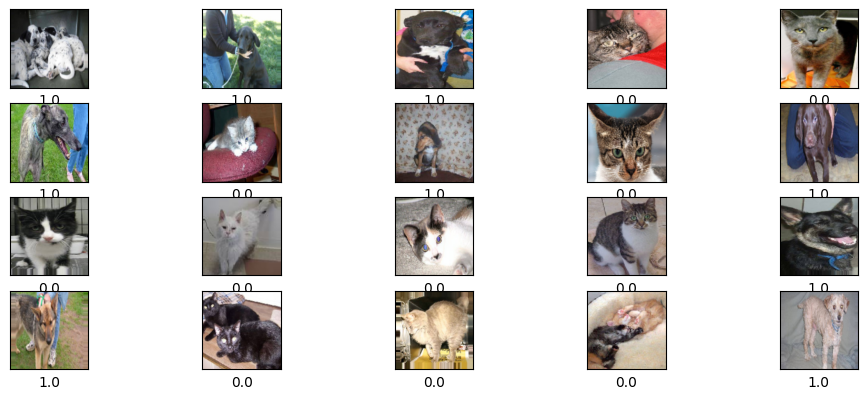

In [3]:

# Obtener un lote de imágenes y etiquetas del generador de entrenamiento
images, labels = next(train_set)

plt.figure(figsize=(12,12))
for i in range(20):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[i])
plt.show()

# Diseño de la red neuronal

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense



### Opción 1: creamos nuestra propia arquitectura

Una primera opción para realizar la clasificación es diseñar nuestra propia red neuronal. Este proceso va a ser más rápido en términos de computación, aunque puede obtener peores métricas.

In [12]:
# Inicializamos la RNC con la función Sequential
rnc = Sequential()

# Añadimos la primera capa de convolución utilizando la función Conv2D (modificamos la forma del input shape que introducimos en la capa de convolución)
rnc.add(Conv2D(filters=32, kernel_size=(3, 3),
               input_shape=[ALTO, ANCHO, 3], activation='relu'))

# Añadimos la primera capa de max pooling utilizando la función MaxPool2D
rnc.add(MaxPool2D(pool_size =(2,2), strides=2))

# Añadimos la segunda capa de convolución + pooling
rnc.add(Conv2D(32, (3, 3), activation='relu'))
rnc.add(MaxPool2D(pool_size=(2, 2)))

# Añadimos la tercera capa de convolución + pooling
rnc.add(Conv2D(64, (3, 3), activation='relu'))
rnc.add(MaxPool2D(pool_size=(2, 2)))

# Añadimos la capa de flattening utilizando la función Flatten
rnc.add(Flatten())

# Añadimos una primera capa oculta utilizando la función Dense igual que hacíamos en las RNA
rnc.add(Dense(units = 64, kernel_initializer = "uniform",  activation = "relu"))

# Añadimos una capa de dropout tras la capa oculta
rnc.add(Dropout(0.5))

# Finalmente añadimos la capa de salida
rnc.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid"))

# Compilamos el modelo
rnc.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy", "Recall", "Precision"])

rnc.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212,513 (4.63 MB)

 Trainable params: 1,212,513 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

### Parametrizando steps_per_epoch


Para setps_per_epoch un buen estándar es el siguiente:

```python
  steps_per_epoch=num_train_images // BATCH_SIZE
```

Una segunda opción es NO parametrizarlo, de esta manera keras lo calculará de forma automática y no habría que preocuparse de quedarse sin suficientes datos durante el entrenamiento -lo cuál provocará un error, que no es grave, pero puede suceder.

Dividiríamos el número todas las imágenes para entrenar entre el tamaño de cada lote. Esta división te va a proporcionar el número exacto de lotes para que entrenar con todas las imágenes. Es la mejor opción.


### Validation_step
Parametrizar validation_step puede ser algo más complicado, aunque una opción es no parametrizarlo.

1. Si pretendes mantener un número fijo y pequeño (es rápido, buena idea para datasets grandes)

```python
validation_steps = 10
```

2. Si el dataset es pequeño y quieres ganar precisión, eliminarías ese parámetro. Por defecto, utilizará todos los lotes de conjunto -recomendado, aunque algo más lento.

```python
#Omitir este parámetro, borrar el steps_per_epoch del model.fit
```

3. Si es un dataset muy grande, calcularlo en tamaños exactos (el número de iágenes del conjunto de validación entre el BATCH):

```python
validation_steps = val_set.n // BATCH_SIZE
```

4. Si hay pocas imágenes en el conjunto de validación (menos que el BATCH_SIZE), mantener un número fijo igual a 1 Este es un caso excepcional:

```python
validation_steps = 1
```

5. Si quieres una medida relativa, puedes usar el tamaño del set entre 100 (parecido a mantener un número fijo y bajo):

```python
validation_steps = val_set.n//100
```

Epoch 1/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 439ms/step - Precision: 0.7367 - Recall: 0.7025 - accuracy: 0.7255 - loss: 0.5280 - val_Precision: 0.8266 - val_Recall: 0.5125 - val_accuracy: 0.7025 - val_loss: 0.5480
Epoch 2/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - Precision: 0.7252 - Recall: 0.6266 - accuracy: 0.7072 - loss: 0.5657 - val_Precision: 0.6674 - val_Recall: 0.7900 - val_accuracy: 0.6981 - val_loss: 0.5712
Epoch 3/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 424ms/step - Precision: 0.7348 - Recall: 0.6861 - accuracy: 0.7228 - loss: 0.5492 - val_Precision: 0.7666 - val_Recall: 0.7063 - val_accuracy: 0.7456 - val_loss: 0.5156
Epoch 4/9
 8/64 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - Precision: 0.7473 - Recall: 0.7679 - accuracy: 0.7469 - loss: 0.5367

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - Precision: 0.6950 - Recall: 0.7377 - accuracy: 0.7223 - loss: 0.5416 - val_Precision: 0.7683 - val_Recall: 0.6300 - val_accuracy: 0.7200 - val_loss: 0.5388
Epoch 5/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - Precision: 0.7815 - Recall: 0.7124 - accuracy: 0.7557 - loss: 0.5148 - val_Precision: 0.7368 - val_Recall: 0.7138 - val_accuracy: 0.7294 - val_loss: 0.5181
Epoch 6/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 451ms/step - Precision: 0.7643 - Recall: 0.7011 - accuracy: 0.7455 - loss: 0.5237 - val_Precision: 0.7925 - val_Recall: 0.6587 - val_accuracy: 0.7431 - val_loss: 0.5162
Epoch 7/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - Precision: 0.7602 - Recall: 0.6954 - accuracy: 0.7341 - loss: 0.5213 - val_Precision: 0.8070 - val_Recall: 0.6637 - val_accuracy: 0.7525 - val_loss: 0.4984
Epoch 8/9
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - Precision: 0.7149 - Recall: 0.7381 - accuracy: 0.7147 - loss: 0.5166 - val_Precision: 0.7719 - val_Recall: 0.7063 - 

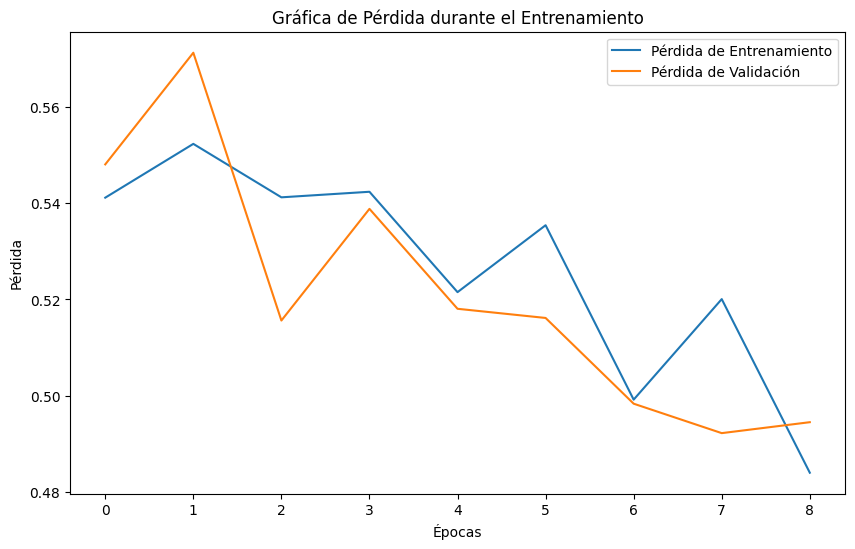

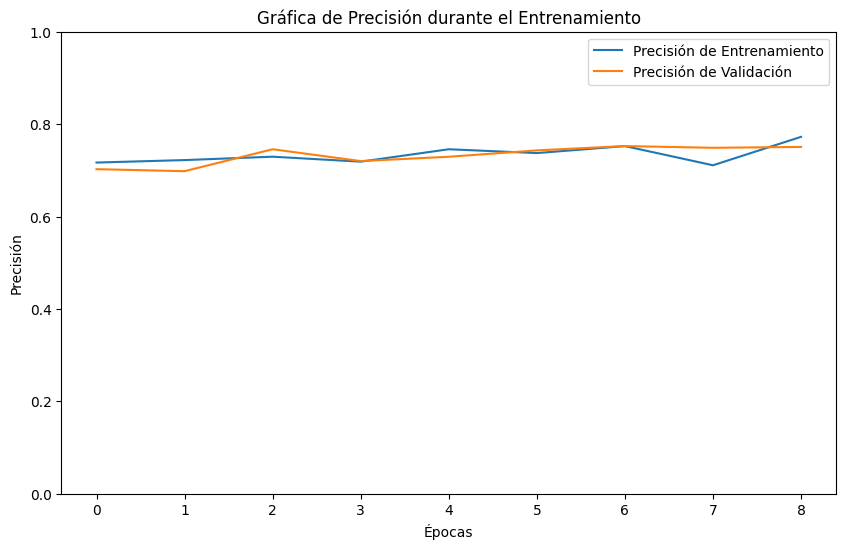

In [14]:
"""

En circunstancias normales, intentaríamos utilizar todo el conjunto de entrenamiento para entrenar el modelo dividiéndole entre el BATCH_SIZE. 

Sin embargo, por falta de tiempo y solamente en este caso en particular, hemos optado por tomar una muestra reducida para cada epoch,
de ahí que hayamos fijado el steps_per_epoch en train_set.n//100 (lo que nos da 64).

Además, puesto que cuando definiemos el train_set activamos el parámetro de "barajar", 
podemos estar tranquilos de que en cada epoch se entrenará con un lote diferente de imágenes.

Esto nos hará ganar velocidad de entrenamiento, lo cuál es ideal para el examen. 

Por otro lado, al omitir el parámetro de validation_steps, el modelo utilizará todo el conjunto de validación para validar el modelo.
Esto debería compensar la falta de entrenamiento con todo el conjunto de train_set.

El resultado es una red neuronal que con poco gasto computacional y con unas métricas "aceptables".

"""



history = rnc.fit(
        train_set,
        steps_per_epoch = train_set.n//100,
        epochs = 9,
        validation_data = val_set,
)

# Graficar la pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Gráfica de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Gráfica de Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [16]:
# Validación en el conjunto TEST

predictions = rnc.predict(test_set)
true_classes = test_set.classes

predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(true_classes, predictions)
precision = precision_score(true_classes, predictions)
recall = recall_score(true_classes, predictions)
f1 = f1_score(true_classes, predictions)

print('Val Accuracy = %.2f' % accuracy)
print('Val Preicision = %.2f' % precision)
print('Val Recall = %.2f' % recall)
print('Val F1 = %.2f' % f1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step
Val Accuracy = 0.78
Val Preicision = 0.79
Val Recall = 0.75
Val F1 = 0.77


Como podemos observar, esta arquitectura nos da un accuracy del 0.5, en otras palabras, no se comporta mejor que un modelo aleatorio y por lo tanto no debería ser utilizado para clasificar imágenes de animales. En su lugar, vamos a probar con la opción nº2.

In [24]:
rnc.save('/content/drive/My Drive/modelo_arquitectura_manual.h5')


### Opción 2: utilizamos el modelo preentrenado de VGG16

Como alternativa a crear nuestra propia arquitectura, otra opción que puede mejorar la eficacia sería utilizar algún algoritmo que ya estuviese preentrenado. Por ejemplo VGG16 es una muy buena opción ya que incluye detección de texturas, contornos, aristas, patrones, objetos, etc. Lo cuál lo hace una opción excelente.

Puesto que tiene un coste computacional mucho mayor que el modelo anterior, esta opción fue entrenada antes de realizar el examen (y de hecho solo se realizaron dos épocas con un accuracy del 89%, aunque la precisión tampoco mejora con un número mayor de épocas, siendo el máximo resultado 92% con 3 epochs).

In [38]:



# Cargamos el modelo base
base_model = VGG16(
     weights="imagenet",
     include_top=False,
     input_shape=[ALTO, ANCHO, 3]
)

#TODO Ahora que tneemos el modelo VGG16, vamos a añadir nuestras capas densas
x = base_model.output
x = Flatten()(x)  # Aplanamos la salida del modelo base
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Añadimos una capa densa con una activación sigmoide

model = Model(inputs=base_model.input, outputs=x)

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy', 'Recall', 'Precision']
)
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,722,881 (56.16 MB)

 Trainable params: 14,722,881 (56.16 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamos el modelo y sacamos las métricas

200/200 ━━━━━━━━━━━━━━━━━━━━ 6665s 33s/step - Precision: 0.9305 - Recall: 0.8926 - accuracy: 0.9143 - loss: 0.2174 - val_Precision: 0.9834 - val_Recall: 0.8875 - val_accuracy: 0.9362 - val_loss: 0.1451


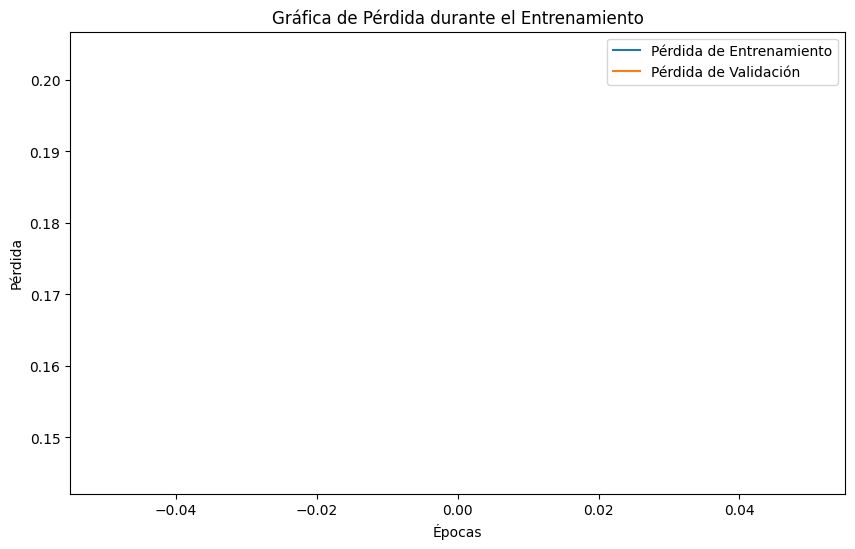

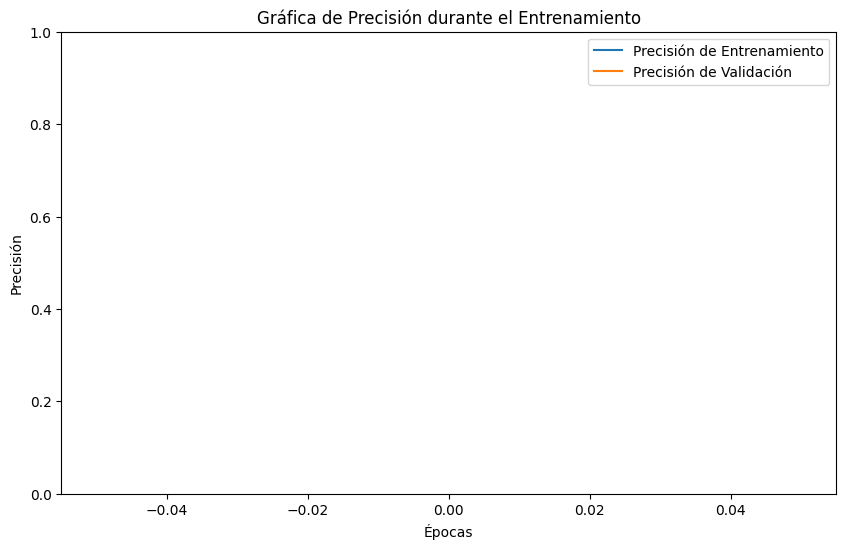

In [40]:
EPOCHS = 1
es = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=3
)

# Número total de imágenes en el conjunto de entrenamiento
num_train_images = train_set.n

# Número total de imágenes en el conjunto de validación
num_val_images = val_set.n

history = model.fit(
    train_set,
    steps_per_epoch=num_train_images // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=num_val_images // BATCH_SIZE,
    callbacks=[es]
)

# Graficar la pérdida (bueno... la intención de graficarla era por si daba tiempo a hacer varios epoch, no ha sido el caso)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Gráfica de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Gráfica de Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim([0, 1])
plt.legend()
plt.show()

Como vemos, el modelo de VGG16 con un accuracy de más del 0.9 ofrece mucho mejor resultado que el anterior. Además, y para averiguar si existe algún tipo de sesgo, procederemos a revisar la matriz de confusión.

In [43]:
# Validación en el conjunto val
predictions = model.predict(test_set)
true_classes = test_set.classes

predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(true_classes, predictions)
precision = precision_score(true_classes, predictions)
recall = recall_score(true_classes, predictions)
f1 = f1_score(true_classes, predictions)

print('Val Accuracy = %.2f' % accuracy)



63/63 ━━━━━━━━━━━━━━━━━━━━ 565s 9s/step
Val Accuracy = 0.95


Precisión:  0.9808510638297873
Sensibilidad:  0.922
F1 0.9505154639175257
[[982  18]
 [ 78 922]]


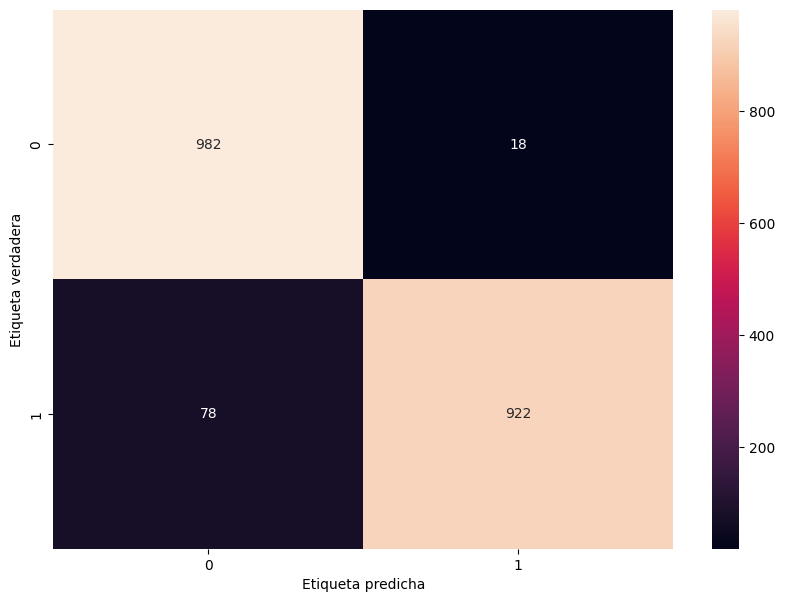

In [44]:

precision = precision_score(true_classes, predictions, zero_division=1)
recall = recall_score(true_classes, predictions, zero_division=1)
f1 = f1_score(true_classes, predictions, zero_division=1)

print("Precisión: ", precision)
print("Sensibilidad: ", recall)
print("F1", f1)

confusion_mtx = confusion_matrix(true_classes, predictions)
import seaborn as sns
print(confusion_mtx)


# Creamos la matriz de confusión
recall = recall_score(true_classes, predictions)
# Visualización de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.show()

Finalmente, y utilizando el VGG16, no solo obtenemos una precisión del 90%, sino que además nos encontramos con que casi todas las imágenes están correctamente clasificadas y sin que haya ningún sesgo aparente hacia ninguno de los dos lados (quizás un ligero sesgo hacia los gatos, aunque nada que sea significativo para este caso).
